High number of pregnancies cause a higher risk of diabetes at greater age

DV: diabetes
IV: pregnancies, age

In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import stan
import csv

In [145]:
import nest_asyncio #this library is important to use pystan

nest_asyncio.apply()

In [146]:
import scipy.stats as stats

In [147]:
## import data

df = pd.read_csv('../db/diabetes.csv')

In [148]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [149]:
df.corr()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.129459,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341,0.221898
Glucose,0.129459,1.000000,0.152590,0.057328,0.331357,0.221071,0.137337,0.263514,0.466581
BloodPressure,0.141282,0.152590,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528,0.065068
SkinThickness,-0.081672,0.057328,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970,0.074752
Insulin,-0.073535,0.331357,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163,0.130548
BMI,0.017683,0.221071,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242,0.292695
DiabetesPedigreeFunction,-0.033523,0.137337,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561,0.173844
Age,0.544341,0.263514,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000,0.238356
Outcome,0.221898,0.466581,0.065068,0.074752,0.130548,0.292695,0.173844,0.238356,1.000000


In [150]:
stan_code = """

data {
int<lower=0> N;
vector[N] y;
vector[N] pregnancies;
vector[N] ages;
}

parameters {
real alpha;
real beta_preg;
real beta_age;
real <lower=0> sigma;
}

model {
//prior 
alpha ~ normal(0,10);
beta_preg ~ normal(0,10);
beta_age~ normal(0,10);
sigma ~ cauchy(0,5);

//model
y ~ normal(pregnancies * beta_preg + ages * beta_age + alpha, sigma);
}

generated quantities {
//predictive posterior check

vector[N] y_rep;

for(n in 1:N){

y_rep[n] = normal_rng(pregnancies[n] * beta_preg + ages[n] * beta_age + alpha, sigma);

}
}
"""

In [151]:
data = {
"N": len(df), 
"pregnancies": df.loc[:, "Pregnancies"].values,
"ages": df.loc[:, "Age"].values,
 "y": df.loc[:, "DiabetesPedigreeFunction"].values,   
}

In [152]:
stan_model = stan.build(stan_code, data=data)

Building: found in cache, done.


In [153]:
fit = stan_model.sample(num_chains=4, num_samples=1000, num_warmup=500) 
## posterior: Stan generates samples from the joint posterior distribution of the parameters

Sampling:   0%
Sampling:   2% (100/6000)
Sampling:   3% (200/6000)
Sampling:   5% (300/6000)
Sampling:   5% (301/6000)
Sampling:   7% (401/6000)
Sampling:  10% (601/6000)
Sampling:  12% (701/6000)
Sampling:  13% (800/6000)
Sampling:  35% (2100/6000)
Sampling:  55% (3300/6000)
Sampling:  77% (4600/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 0.000204 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.04 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000211 seconds
  1000 transitions using 10 leapfrog steps per transition would take 2.11 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.00018 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.8 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000181 seconds
  1000 transitions using 10 leapfrog steps per transition

In [154]:
stan_data_simu_v1 = az.from_pystan(
    posterior=fit,
    posterior_predictive="y_rep",
    observed_data=["y"],
    posterior_model=stan_model,
    coords={"y_hat": np.arange(data["N"])},
)

<Axes: xlabel='y / y_rep'>

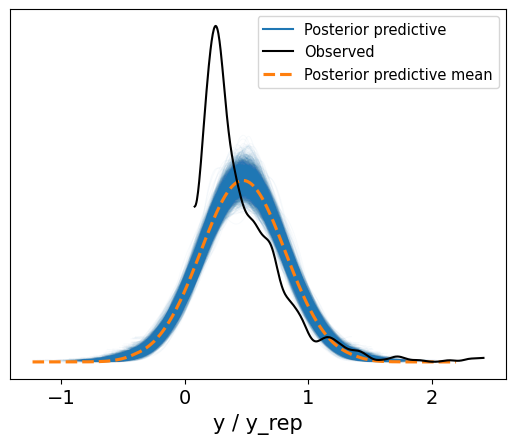

In [160]:
az.plot_ppc(stan_data_simu_v1, data_pairs={"y": "y_rep"}, alpha=0.03, textsize=14)

In [155]:
fit.to_frame()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,beta_preg,beta_age,...,y_rep.759,y_rep.760,y_rep.761,y_rep.762,y_rep.763,y_rep.764,y_rep.765,y_rep.766,y_rep.767,y_rep.768
draws,,,,,,,,,,,,,,,,,,,,,
0,463.120375,0.804730,0.076973,4.0,27.0,0.0,-458.331881,0.438485,-0.014117,0.003177,...,0.869270,0.575696,0.774023,0.663901,0.190021,0.239175,0.591171,0.476658,0.411181,0.463165
1,464.030892,0.939088,0.064904,5.0,31.0,0.0,-462.771399,0.453704,-0.007053,0.001716,...,0.076204,1.095105,0.771687,0.520609,1.021238,0.365668,-0.191340,0.198672,0.861318,0.579391
2,462.932996,0.998303,0.074169,3.0,15.0,0.0,-460.751165,0.487049,-0.010009,0.000512,...,0.786964,0.706836,0.603821,-0.158684,0.309578,0.369063,-0.019534,0.561399,0.540550,0.645826
3,460.623386,0.995801,0.070407,3.0,7.0,0.0,-460.338492,0.525461,0.001777,-0.001660,...,0.690682,0.655512,0.631031,0.681449,0.740389,0.760184,0.519880,1.055387,0.819935,0.425520
4,463.119219,0.994811,0.076973,4.0,31.0,0.0,-461.631885,0.458696,-0.015145,0.002497,...,0.994503,0.480529,0.550440,1.099239,0.626572,0.728001,0.153439,0.132701,0.858793,0.444258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,461.875693,0.997032,0.070407,5.0,31.0,0.0,-460.648259,0.392959,-0.015619,0.004307,...,0.854015,0.140998,0.568731,-0.178904,0.784253,0.435319,0.206478,0.979575,0.722648,0.585326
3996,462.972979,1.000000,0.076973,2.0,7.0,0.0,-462.096412,0.422489,-0.008489,0.001810,...,0.841942,0.903151,0.908973,0.575386,0.485542,0.498838,0.687382,0.097390,1.077718,0.378402
3997,465.306509,0.976686,0.064904,5.0,31.0,0.0,-460.370761,0.420939,-0.009422,0.002608,...,0.537978,0.200308,0.125491,0.421742,0.386457,0.063342,0.572435,-0.371020,0.840837,0.288989


<Axes: >

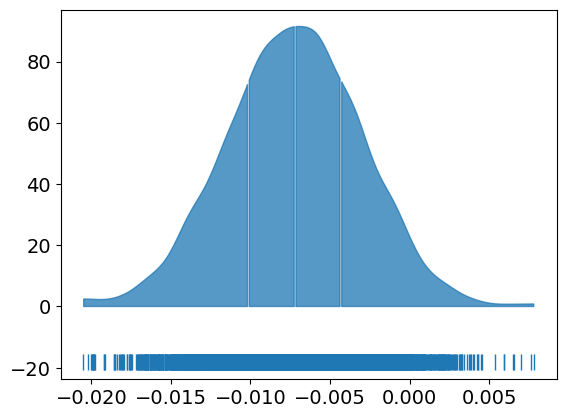

In [156]:
az.plot_dist(fit['beta_preg'], rug=True, quantiles=[.25, .5, .75])

<Axes: >

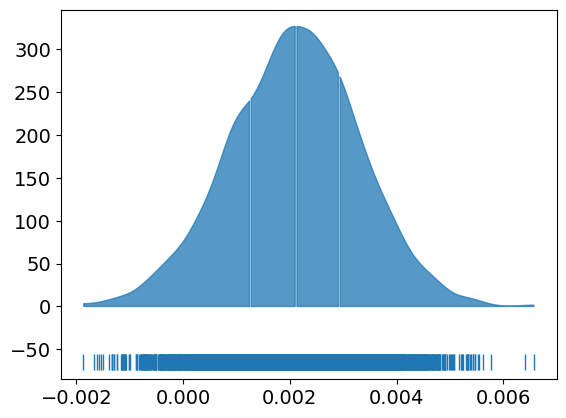

In [157]:
az.plot_dist(fit['beta_age'], rug=True, quantiles=[.25, .5, .75])

<Axes: >

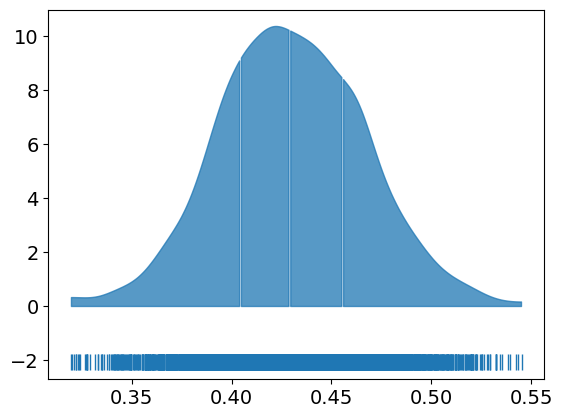

In [158]:
az.plot_dist(fit['alpha'], rug=True, quantiles=[.25, .5, .75])

Picking 1,000 values from updated distribution (posterior distribution). Picking 1,000, four times.
Draws 1 data means what has been sampled after being MCMC sampling.

In [159]:
summary1 = az.summary(fit) #https://python.arviz.org/en/stable/getting_started/Introduction.html

In [161]:
summary1

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.430,0.036,0.363,0.500,0.001,0.001,1422.0,1479.0,1.0
beta_preg,-0.007,0.004,-0.015,0.001,0.000,0.000,3282.0,2545.0,1.0
beta_age,0.002,0.001,-0.000,0.004,0.000,0.000,1614.0,2025.0,1.0
sigma,0.332,0.008,0.317,0.347,0.000,0.000,1959.0,1969.0,1.0
y_rep[0],0.493,0.331,-0.151,1.101,0.005,0.004,3900.0,3997.0,1.0
...,...,...,...,...,...,...,...,...,...
y_rep[763],0.500,0.333,-0.096,1.134,0.005,0.004,3838.0,3636.0,1.0
y_rep[764],0.471,0.332,-0.151,1.082,0.005,0.004,4033.0,4043.0,1.0
y_rep[765],0.449,0.333,-0.180,1.074,0.005,0.004,3898.0,3911.0,1.0
y_rep[766],0.522,0.331,-0.086,1.165,0.005,0.004,3646.0,3818.0,1.0


<Axes: >

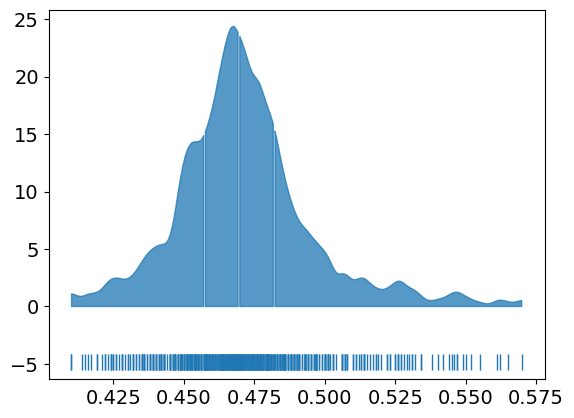

In [162]:
az.plot_dist(summary1['mean'][5:], rug=True, quantiles=[.25, .5, .75])

alpha and beta parameters after being updated with prior is 0.484 and -0.003 repectively.

In [163]:
stan_code_v2 = """

data {
int<lower=0> N;
vector[N] y;
vector[N] pregnancies;
vector[N] ages;
}

parameters {
real alpha;
real beta_preg;
real beta_age;
real <lower=0> sigma;
}

model {
//prior 
alpha ~ normal(0,0.46);
beta_preg ~ normal(0,10);
beta_age~ normal(0,10);
sigma ~ cauchy(0,5);

//model
y ~ normal(pregnancies * beta_preg + ages * beta_age + alpha, sigma);
}

generated quantities {
//predictive posterior check

vector[N] y_rep;

for(n in 1:N){

y_rep[n] = normal_rng(pregnancies[n] * beta_preg + ages[n] * beta_age + alpha, sigma);

}
}
"""

In [164]:
stan_model_v2 = stan.build(stan_code_v2, data=data)

Building: found in cache, done.


In [165]:
fit2 = stan_model_v2.sample(num_chains=4, num_samples=1000, num_warmup=500) 
## posterior: Stan generates samples from the joint posterior distribution of the parameters

Sampling:   0%
Sampling:   2% (100/6000)
Sampling:   5% (300/6000)
Sampling:   7% (400/6000)
Sampling:   7% (401/6000)
Sampling:   8% (501/6000)
Sampling:  12% (701/6000)
Sampling:  13% (801/6000)
Sampling:  38% (2300/6000)
Sampling:  60% (3600/6000)
Sampling:  78% (4700/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 0.000187 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.87 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000179 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.79 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000181 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.81 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.000182 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.82 seconds

In [166]:
fit2.to_frame()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,beta_preg,beta_age,...,y_rep.759,y_rep.760,y_rep.761,y_rep.762,y_rep.763,y_rep.764,y_rep.765,y_rep.766,y_rep.767,y_rep.768
draws,,,,,,,,,,,,,,,,,,,,,
0,462.491975,0.831535,0.065382,5.0,63.0,0.0,-460.406533,0.382297,-0.003406,0.002391,...,0.630558,0.536682,0.573903,0.226586,0.242461,0.862715,-0.072235,0.391207,0.298641,0.861133
1,462.667433,0.461074,0.058472,3.0,7.0,0.0,-458.185021,0.465561,-0.006580,0.000407,...,0.396888,0.725134,0.821350,0.453687,0.189348,0.282817,0.512237,0.269987,-0.070744,0.132645
2,464.529797,0.952048,0.071984,5.0,47.0,0.0,-459.747113,0.394990,-0.007992,0.003368,...,-0.227585,0.110957,0.012774,0.310670,0.753860,0.701282,0.300469,1.000726,0.765426,0.322567
3,463.362673,0.993568,0.063055,5.0,63.0,0.0,-463.041621,0.474236,-0.004136,0.000198,...,0.552958,-0.156287,0.870237,0.049110,0.180666,0.369867,0.360820,-0.101880,0.099780,0.586509
4,463.238704,0.999681,0.065382,5.0,31.0,0.0,-461.786030,0.389817,-0.009349,0.002927,...,-0.004008,0.143313,0.529034,0.272716,0.321675,0.347461,0.585900,-0.053229,0.289343,0.604605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,461.850576,0.931984,0.063055,4.0,15.0,0.0,-461.445656,0.413823,-0.016959,0.003378,...,0.375285,0.013663,0.634844,-0.145809,-0.039264,0.345368,-0.133639,0.055918,0.587633,0.840300
3996,464.834184,0.993486,0.065382,4.0,31.0,0.0,-462.243517,0.456888,-0.005718,0.001247,...,0.661785,0.441041,0.216845,0.861764,0.404561,0.884774,0.661304,0.802935,0.742522,0.722011
3997,461.321851,0.584491,0.058472,5.0,55.0,0.0,-456.743845,0.425614,-0.006725,0.003044,...,0.611144,-0.180150,0.869482,0.421385,0.146824,0.365298,-0.130819,0.447088,0.402322,0.146067


<Axes: >

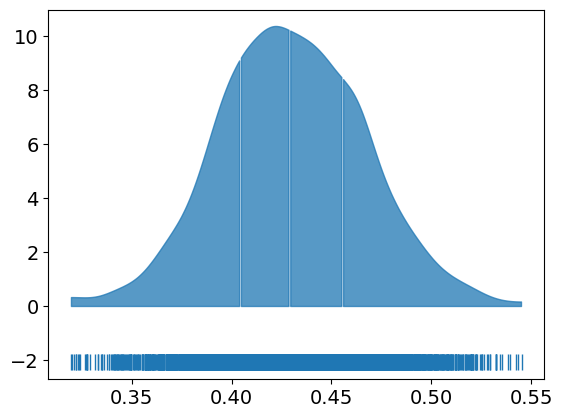

In [167]:
az.plot_dist(fit['alpha'], rug=True, quantiles=[.25, .5, .75])

In [168]:
summary2 = az.summary(fit) #https://python.arviz.org/en/stable/getting_started/Introduction.html

In [169]:
summary2

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.430,0.036,0.363,0.500,0.001,0.001,1422.0,1479.0,1.0
beta_preg,-0.007,0.004,-0.015,0.001,0.000,0.000,3282.0,2545.0,1.0
beta_age,0.002,0.001,-0.000,0.004,0.000,0.000,1614.0,2025.0,1.0
sigma,0.332,0.008,0.317,0.347,0.000,0.000,1959.0,1969.0,1.0
y_rep[0],0.493,0.331,-0.151,1.101,0.005,0.004,3900.0,3997.0,1.0
...,...,...,...,...,...,...,...,...,...
y_rep[763],0.500,0.333,-0.096,1.134,0.005,0.004,3838.0,3636.0,1.0
y_rep[764],0.471,0.332,-0.151,1.082,0.005,0.004,4033.0,4043.0,1.0
y_rep[765],0.449,0.333,-0.180,1.074,0.005,0.004,3898.0,3911.0,1.0
y_rep[766],0.522,0.331,-0.086,1.165,0.005,0.004,3646.0,3818.0,1.0


<Axes: >

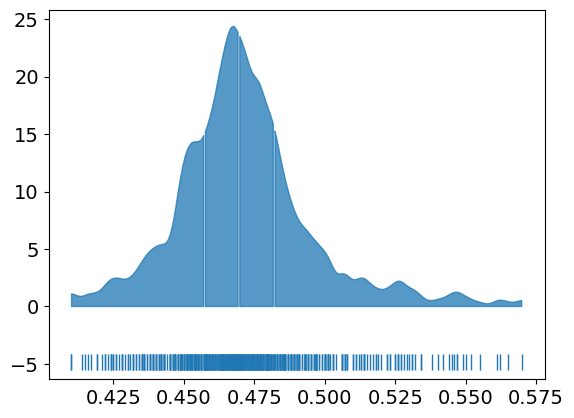

In [170]:
az.plot_dist(summary2['mean'][5:], rug=True, quantiles=[.25, .5, .75])

In [174]:
stan_data_simu_v2 = az.from_pystan(
    posterior=fit2,
    posterior_predictive=["y_rep"],
    observed_data=["y"],
    posterior_model=stan_model_v2,
    coords={"y_hat": np.arange(data["N"])},
)

<Axes: xlabel='y / y_rep'>

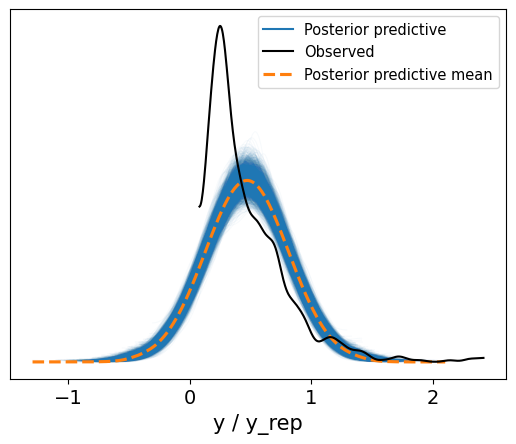

In [178]:
az.plot_ppc(stan_data_simu_v2, data_pairs={"y": "y_rep"}, alpha=0.03, textsize=14)

In [173]:
stan_code_v3 = """

data {
int<lower=0> N;
vector[N] y;
vector[N] pregnancies;
vector[N] ages;
}

parameters {
real alpha;
real beta_preg;
real beta_age;
real <lower=0> sigma;
}

model {
//prior 
alpha ~ normal(0.46,5);
beta_preg ~ normal(-0.001,5);
beta_age~ normal(0.1,5);
sigma ~ cauchy(0,5);

//model
y ~ normal(pregnancies * beta_preg + ages * beta_age + alpha, sigma);
}

generated quantities {
//predictive posterior check

vector[N] y_rep;

for(n in 1:N){

y_rep[n] = normal_rng(pregnancies[n] * beta_preg + ages[n] * beta_age + alpha, sigma);

}
}
"""

In [126]:
stan_model_v3 = stan.build(stan_code_v3, data=data)

Building: 0.2s
Building: 0.4s
Building: 0.5s
Building: 0.6s
Building: 0.7s
Building: 0.8s
Building: 0.9s
Building: 1.0s
Building: 1.1s
Building: 1.2s
Building: 1.3s
Building: 1.4s
Building: 1.5s
Building: 1.6s
Building: 1.7s
Building: 1.8s
Building: 1.9s
Building: 2.0s
Building: 2.1s
Building: 2.2s
Building: 2.3s
Building: 2.4s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/vcmluoai/model_vcmluoai.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:8:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/chainable_object.hpp:6:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/typedefs.hpp:7:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-pac

Building: 2.5s
Building: 2.6s
Building: 2.7s
Building: 2.8s
Building: 2.9s
Building: 3.0s
Building: 3.1s
Building: 3.2s
Building: 3.3s
Building: 3.4s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/vcmluoai/model_vcmluoai.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:26:
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/beta.hpp:70:32: warning: lambda capture 'b' is not used [-Wunused-lambda-capture]
                           [a, b, digamma_ab](auto& vi) mutable {
                             ~~^


Building: 3.6s
Building: 3.7s
Building: 3.8s
Building: 3.9s
Building: 4.0s
Building: 4.1s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/vcmluoai/model_vcmluoai.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:55:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/

Building: 4.2s
Building: 4.3s
Building: 4.4s
Building: 4.5s
Building: 4.6s
Building: 4.7s
Building: 4.8s
Building: 4.9s
Building: 5.0s
Building: 5.1s
Building: 5.2s
Building: 5.3s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/vcmluoai/model_vcmluoai.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:198:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/functor.hpp:12:
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/functor/hcubature.hpp:468:7: warning: unused variable 'kdiv' [-Wunused-variable]
  int kdiv = kdivide;
      ^


Building: 5.4s
Building: 5.5s
Building: 5.6s
Building: 5.7s
Building: 5.8s
Building: 5.9s
Building: 6.0s
Building: 6.1s
Building: 6.2s
Building: 6.3s
Building: 6.4s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/vcmluoai/model_vcmluoai.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:198:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/functor.hpp:15:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/functor/integrate_ode_rk45.hpp:6:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-

Building: 6.5s
Building: 6.6s
Building: 6.7s
Building: 6.8s
Building: 7.0s
Building: 7.1s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/vcmluoai/model_vcmluoai.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:14:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim.hpp:16:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob.hpp:128:
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob/gaussian_dlm_obs_rng.hpp:98:7: warning: unused variable 'n' [-Wunused-variable]
  int n = G.rows();  // number of states
      ^


Building: 7.2s
Building: 7.3s
Building: 7.4s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/vcmluoai/model_vcmluoai.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:14:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim.hpp:16:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob.hpp:210:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob/multi_student_t_log.hpp:5:
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan

Building: 7.5s
Building: 7.6s
Building: 7.7s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/vcmluoai/model_vcmluoai.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:14:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim.hpp:16:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob.hpp:312:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob/skew_double_exponential_ccdf_log.hpp:5:
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan

Building: 7.8s
Building: 7.9s


/Users/eunkang/Library/Caches/httpstan/4.10.1/models/vcmluoai/model_vcmluoai.cpp:298:11: warning: variable 'pos__' set but not used [-Wunused-but-set-variable]
      int pos__ = std::numeric_limits<int>::min();
          ^
/Users/eunkang/Library/Caches/httpstan/4.10.1/models/vcmluoai/model_vcmluoai.cpp:343:11: warning: variable 'pos__' set but not used [-Wunused-but-set-variable]
      int pos__ = std::numeric_limits<int>::min();
          ^


Building: 8.0s
Building: 8.1s
Building: 8.2s
Building: 8.3s
Building: 8.4s
Building: 8.5s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/vcmluoai/model_vcmluoai.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:55:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/

Building: 8.6s
Building: 8.7s
Building: 8.8s
Building: 8.9s
Building: 9.0s


/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp:192:12: warning: unused variable 'pre_mult' [-Wunused-variable]
      auto pre_mult = a2 * pow(1 - z, -1 - a2);
           ^
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp:307:20: note: in instantiation of function template specialization 'stan::math::internal::grad_2F1_impl<true, true, true, true, stan::math::var_value<double>, stan::math::var_value<double>, stan::math::var_value<double>, stan::math::var_value<double>, stan::math::var_value<double>, std::tuple<stan::math::var_value<double>, stan::math::var_value<double>, stan::math::var_value<double>, stan::math::var_value<double>>>' requested here
  return internal::grad_2F1_impl<true, true, true, true>(a1, a2, b1, z,
                   ^
In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/vcmluoai/model_vcmluoai.cpp:2:
In file i

Building: 9.1s
Building: 9.2s
Building: 9.3s
Building: 9.4s
Building: 9.5s
Building: 9.7s
Building: 9.8s
Building: 9.9s
Building: 10.0s
Building: 10.1s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/vcmluoai/model_vcmluoai.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:100:
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/lb_constrain.hpp:114:33: warning: lambda capture 'lp' is not used [-Wunused-lambda-capture]
                               [lp, arena_lb = var(lb)](auto& vi) mutable {
                                ^
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/h

Building: 10.2s
Building: 10.3s
Building: 10.4s
Building: 10.5s
Building: 10.6s
Building: 10.7s
Building: 10.8s
Building: 10.9s
Building: 11.0s
Building: 11.1s
Building: 11.2s
Building: 11.3s
Building: 11.4s
Building: 11.5s
Building: 11.6s
Building: 11.7s
Building: 11.8s
Building: 11.9s
Building: 12.0s
Building: 12.1s
Building: 12.2s
Building: 12.3s
Building: 12.4s
Building: 12.5s
Building: 12.6s
Building: 12.7s
Building: 12.8s
Building: 12.9s
Building: 13.0s
Building: 13.2s
Building: 13.3s
Building: 13.4s
Building: 13.5s
Building: 13.6s
Building: 13.7s
Building: 13.8s
Building: 13.9s
Building: 14.0s
Building: 14.1s
Building: 14.2s


21 warnings generated.
ld: warning: object file (/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/stan_services.o) was built for newer macOS version (11.0) than being linked (10.9)
ld: warning: dylib (/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/lib/libtbbmalloc_proxy.dylib) was built for newer macOS version (10.11) than being linked (10.9)
ld: warning: dylib (/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/lib/libtbb.dylib) was built for newer macOS version (10.11) than being linked (10.9)
ld: warning: dylib (/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/lib/libtbbmalloc.dylib) was built for newer macOS version (10.11) than being linked (10.9)
ld: warning: object file (/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/lib/libsundials_nvecserial.a(nvector_serial.o)) was built for newer macOS version (11.0) than being linked (10.9)
ld: warning: ob

In [127]:
fit3 = stan_model_v3.sample(num_chains=4, num_samples=1000, num_warmup=500) 
## posterior: Stan generates samples from the joint posterior distribution of the parameters

Sampling:   0%
Sampling:   2% (100/6000)
Sampling:   3% (200/6000)
Sampling:   5% (300/6000)
Sampling:   7% (400/6000)
Sampling:  10% (600/6000)
Sampling:  13% (800/6000)
Sampling:  17% (1000/6000)
Sampling:  20% (1200/6000)
Sampling:  40% (2400/6000)
Sampling:  60% (3600/6000)
Sampling:  80% (4800/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 0.002108 seconds
  1000 transitions using 10 leapfrog steps per transition would take 21.08 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.001981 seconds
  1000 transitions using 10 leapfrog steps per transition would take 19.81 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.002 seconds
  1000 transitions using 10 leapfrog steps per transition would take 20 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 0.001969 seconds
  1000 transitions using 10 leapfrog steps per transitio

In [128]:
fit3.to_frame()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,beta_preg,beta_age,...,y_rep.759,y_rep.760,y_rep.761,y_rep.762,y_rep.763,y_rep.764,y_rep.765,y_rep.766,y_rep.767,y_rep.768
draws,,,,,,,,,,,,,,,,,,,,,
0,465.065981,0.933806,0.066428,4.0,23.0,0.0,-462.669947,0.425601,-0.004001,0.001725,...,0.123740,0.969734,0.638962,0.111830,0.593819,0.732826,0.342898,0.734392,0.384157,0.578082
1,464.760676,0.979321,0.061901,6.0,63.0,0.0,-463.879511,0.385334,-0.006779,0.003242,...,0.056358,0.444421,-0.446675,0.226342,0.350224,0.246025,0.558950,0.803590,-0.047389,0.858609
2,462.465160,0.892845,0.065100,5.0,31.0,0.0,-458.294388,0.459396,0.002831,-0.000144,...,0.746894,0.563387,0.207822,0.859849,0.688515,0.983255,1.227275,0.149472,0.098345,0.658865
3,465.247563,0.995583,0.065499,6.0,63.0,0.0,-464.002628,0.455014,-0.006672,0.001184,...,0.428929,1.061931,0.995807,0.033534,0.412415,0.612790,0.751089,0.220189,1.244035,0.691938
4,463.120864,0.992550,0.066428,5.0,31.0,0.0,-462.766050,0.415717,-0.001152,0.001848,...,-0.050874,0.059172,0.549135,0.435100,0.420003,0.148732,0.208243,0.517494,0.554888,0.477170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,463.530641,0.998308,0.065499,5.0,63.0,0.0,-460.208580,0.391797,-0.007293,0.003386,...,0.364307,0.981565,0.538736,0.998071,0.434791,0.881081,0.272522,0.173393,0.664828,0.346115
3996,465.321727,0.996239,0.066428,5.0,47.0,0.0,-463.874823,0.420538,-0.004394,0.001963,...,-0.197189,0.703406,-0.053445,0.356437,0.725316,0.722714,0.634440,0.769134,0.799108,0.290251
3997,463.382771,1.000000,0.061901,2.0,3.0,0.0,-462.887984,0.381638,-0.002158,0.002547,...,0.666234,0.435681,0.753072,0.681855,0.341309,0.618688,0.448082,0.635478,0.881930,0.434052


In [134]:
summary3 = az.summary(fit3) #https://python.arviz.org/en/stable/getting_started/Introduction.html

In [135]:
summary3

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.430,0.036,0.364,0.498,0.001,0.001,1796.0,1859.0,1.0
beta_preg,-0.007,0.004,-0.015,0.001,0.000,0.000,3006.0,2032.0,1.0
beta_age,0.002,0.001,-0.000,0.004,0.000,0.000,1956.0,2130.0,1.0
sigma,0.331,0.009,0.316,0.348,0.000,0.000,1732.0,1740.0,1.0
y_rep[0],0.492,0.330,-0.103,1.111,0.005,0.004,4054.0,3814.0,1.0
...,...,...,...,...,...,...,...,...,...
y_rep[763],0.484,0.338,-0.109,1.165,0.005,0.004,3811.0,3748.0,1.0
y_rep[764],0.476,0.336,-0.139,1.123,0.005,0.004,4138.0,3931.0,1.0
y_rep[765],0.455,0.330,-0.125,1.095,0.005,0.004,3931.0,4014.0,1.0
y_rep[766],0.525,0.328,-0.058,1.152,0.005,0.004,3974.0,3868.0,1.0


<Axes: >

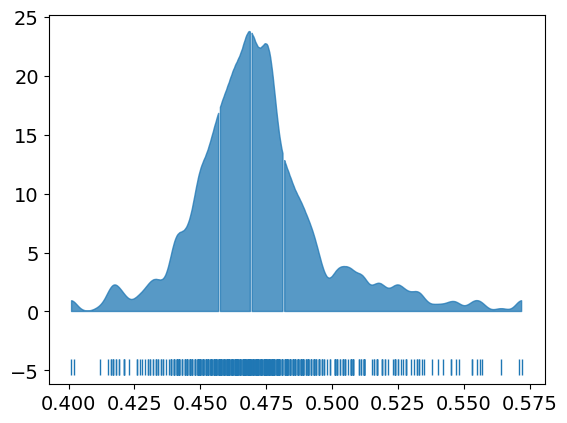

In [136]:
az.plot_dist(summary3['mean'][5:], rug=True, quantiles=[.25, .5, .75])

In [179]:
stan_data_simu_v3 = az.from_pystan(
    posterior=fit3,
    posterior_predictive=["y_rep"],
    observed_data=["y"],
    posterior_model=stan_model_v3,
    coords={"y_hat": np.arange(data["N"])},
)

In [180]:
stan_data_simu_v3

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='y / y_rep'>

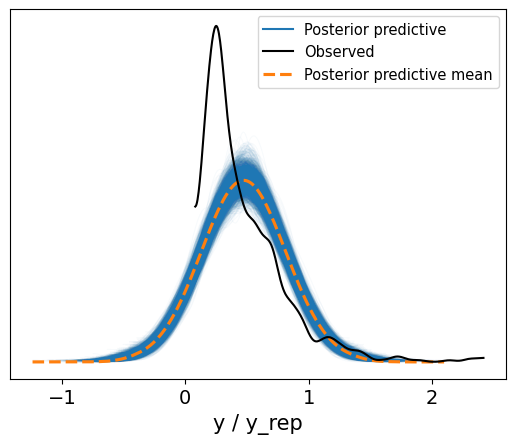

In [133]:
az.plot_ppc(stan_data_simu_v3, data_pairs={"y": "y_rep"}, alpha=0.03, textsize=14)

In [69]:
# import the relevant modules
import shutil
import httpstan.models
import httpstan.cache

In [70]:
httpstan.cache.list_model_names()

['models/mpcoygir', 'models/wxzjwpis', 'models/dr5vcctp']

In [73]:
httpstan.cache.delete_model_directory('models/mpcoygir') ## add the model pointer you want to remove